# Imports and Installations

In [135]:
#First install pyRDDL as following

!pip install -q git+https://github.com/tasbolat1/pyRDDLGym.git --force-reinstall

## Install other packages if needed

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aivle-gym 0.2.1 requires numpy==1.24.2, but you have numpy 1.24.4 which is incompatible.


In [136]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import itertools
import numpy as np
import random
import tqdm
import matplotlib.pyplot as plt
from collections import deque

from pyRDDLGym.Visualizer.MovieGenerator import MovieGenerator # loads visualizer utilites
from IPython.display import Image, display, clear_output # for displaying gifs in colab
from pyRDDLGym.Elevator import Elevator # imports Discrete Elevator

## Add more imports here
from collections import namedtuple, deque
import math

# Environment Initialization

In [137]:
env = Elevator(instance = 4)
print('Discrete environment actions:')
print(env.disc_actions)
print('Continuous environment actions:')
print(env.base_env.action_space)
print(f"Observation space size for the discrete Elevator Environment: {len(env.disc_states)}")

/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/pyRDDLGym/Examples /home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/pyRDDLGym/Examples/manifest.csv
Available example environment(s):
Elevators -> The Elevator domain models evening rush hours when people from different floors in a building want to go down to the bottom floor using elevators.
Traffic -> BLX/QTM traffic model.
SupplyChain -> A supply chain with factory and multiple warehouses.
Wildfire -> A boolean version of the wildfire fighting domain.
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
CartPole_continuous -> A simple continuous state-action MDP for the classical cart-pole system by Rich Sutton, with actions that describe the continuous force applied to the cart.
UAV_discrete -> Discrete action space version of multi-UAV problem where a group of UAVs hav

/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/pyRDDLGym/Core/Env/RDDLConstraints.py:85: UserWarning: Constraint does not have a structure of <action or state fluent> <op> <rhs>, where:
<op> is one of {<=, <, >=, >}
<rhs> is a deterministic function of non-fluents or constants only.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(


Discrete environment actions:
{0: ('e0_movcurdir_0',), 1: ('e0_movcurdir_1',), 2: ('e0_close_0',), 3: ('e0_close_1',), 4: ('e0_open_0',), 5: ('e0_open_1',)}
Continuous environment actions:
Dict('move-current-dir___e0': Discrete(2), 'open-door___e0': Discrete(2), 'close-door___e0': Discrete(2))
Observation space size for the discrete Elevator Environment: 45056


# Hyperparameters

In [138]:
# Define hyperparameters

## IMPORTANT: <BEGIN> DO NOT CHANGE THIS CODE!
## GENERAL HYPERPARAMS
num_episodes = 3000
## IMPORTANT: <END> DO NOT CHANGE THIS CODE!

learning_rate = 5e-4 #3e-4
batch_size = 32
clip_value = 1.0  # Gradient clipping value

## ALGO SPECIFIC HYPERPARAMS
# Update the hyperparams as necessary for your implementation
gamma = 0.99
initial_epsilon = 1.0
end_epsilon = 0.05
epsilon_decay = 1000
replay_buffer_size = 100000
tau = 0.005

# Model Definition (COPY THIS OVER TO your AGENT.PY)


In [139]:
# Define the Model here - all component models (in case of actor-critic or others) MUST subclass nn.Module
class DQN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(DQN, self).__init__()
        # Your model layers and initializations here
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x will be a tensor with shape [batch_size, 11]
        # Your forward pass logic here
        # Ensure the output has shape [batch_size, 6]
        output = self.relu(self.fc1(x))
        output = self.relu(self.fc2(output))
        output = self.fc3(output)
        return output

# Feature Extraction

In [140]:
## IMPORTANT: DO NOT CHANGE THIS CODE!
env_features = list(env.observation_space.keys())

def convert_state_to_list(state, env_features):
    out = []
    for i in env_features:
        out.append(state[i])
    return out

# Neural Net Initialization

In [141]:
# Initialize the network and optimizer
input_size = len(env_features)
output_size = 6

# INITIALIZE OTHER NETWORK PARAMS HERE
hidden_size = 64

# INITIALIZE YOUR NETWORK HERE
policy_net = DQN(input_size, output_size, hidden_size)
target_net = DQN(input_size, output_size, hidden_size)
target_net.load_state_dict(policy_net.state_dict())

# INIT OPTIMIZER - Adam is a good start, but you can try changing this as well
optimizer = optim.Adam(
    policy_net.parameters(), lr=learning_rate, amsgrad=True
)

In [142]:
# Convert networks to CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
policy_net.to(device)
target_net.to(device)

# Define other constructs (replay buffers, etc) as necessary
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

## Gradient Clipping (Optional, you can use torch's version as well)

In [143]:
# Define a function for gradient clipping
def clip_grads(model, clip_value):
    for param in model.parameters():
        if param.grad is not None:
            param.grad.data = torch.clamp(param.grad.data, -clip_value, clip_value)

# Live Plotting Setup

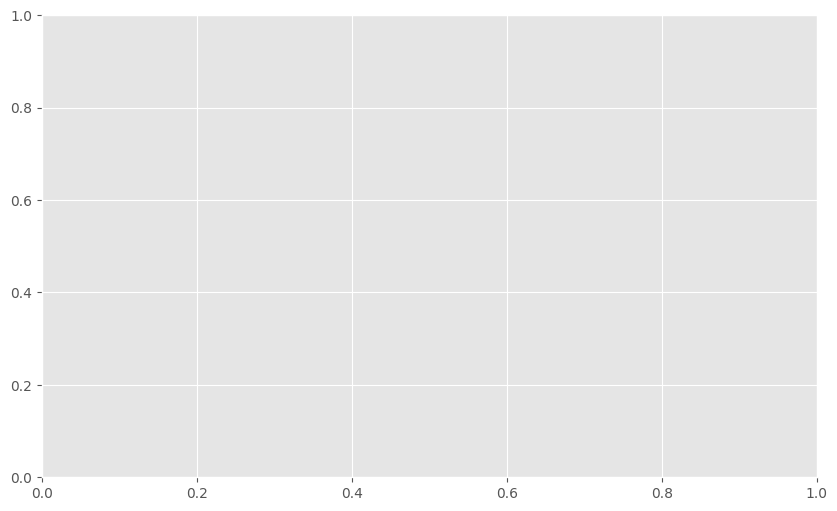

In [144]:
%matplotlib inline
# Create a figure for plotting
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.ion()

# Lists to store rewards and episode numbers
rewards_list = []
episodes = []

def exponential_smoothing(data, alpha=0.1):
    """Compute exponential smoothing."""
    smoothed = [data[0]]  # Initialize with the first data point
    for i in range(1, len(data)):
        st = alpha * data[i] + (1 - alpha) * smoothed[-1]
        smoothed.append(st)
    return smoothed

def live_plot(data_dict, figure, ylabel="Total Rewards"):
    """Plot the live graph."""
    clear_output(wait=True)
    ax.clear()
    for label, data in data_dict.items():
        if label == "Total Reward":
            ax.plot(data, label=label, color="yellow", linestyle='--')

            # Compute and plot moving average for total reward
            ma = exponential_smoothing(data)
            ma_idx_start = len(data) - len(ma)
            ax.plot(range(ma_idx_start, len(data)), ma, label="Smoothed Value", linestyle="-", color="purple", linewidth=2)
        else:
            ax.plot(data, label=label)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper left')
    display(figure)


# RL Algorithm

In [145]:
# Define the loss calculation function
def calculate_loss(
    ## INCLUDE PARAMS YOU NEED HERE
    state_action_values, expected_state_action_values
    ):
    ## TODO - CALCULATE LOSS VALUE & RETURN IT
    # Calculate Huber loss
    loss = nn.SmoothL1Loss()(state_action_values, expected_state_action_values)

    return loss

In [146]:
steps_done = 0

def choose_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = end_epsilon + (initial_epsilon - end_epsilon) * \
        math.exp(-1. * steps_done / epsilon_decay)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


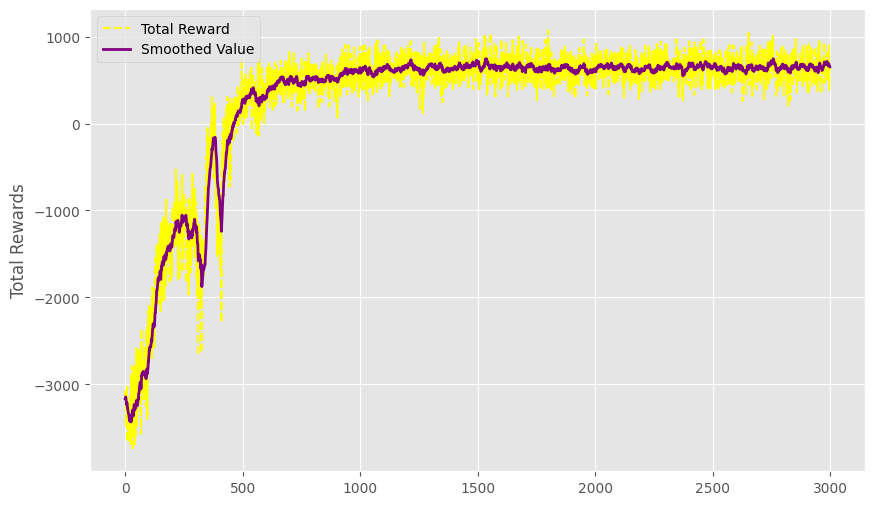

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [1:14:02<00:00,  1.48s/it, Total Reward=664, Loss=3.79]


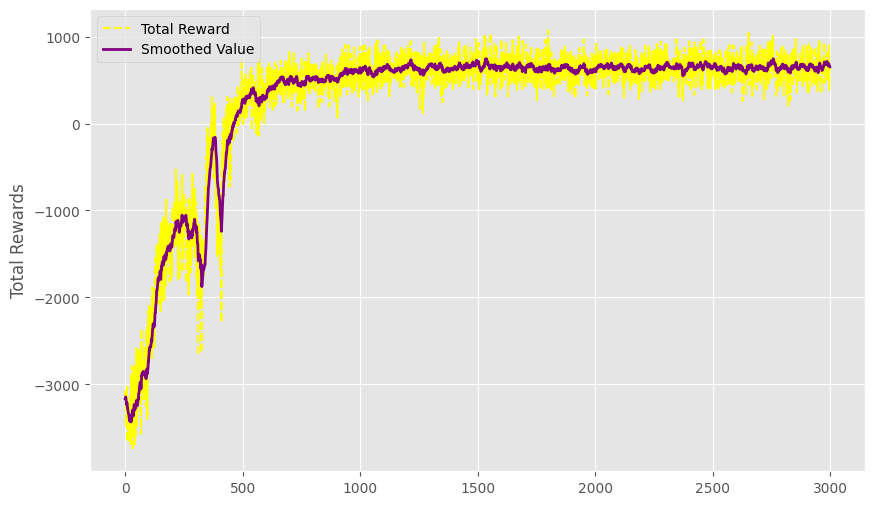

In [147]:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(10, 6))
plt.ion()

# Create a tqdm progress bar
progress_bar = tqdm.tqdm(range(num_episodes), postfix={'Total Reward': 0, 'Loss': 0})

# Initialize your ReplayBuffer
replay_buffer = ReplayBuffer(replay_buffer_size)

# RL algorithm training loop
for episode in progress_bar:
    total_reward = 0
    state = env.reset()

    while True:
        # Convert the original state to the suitable format for the network
        state_desc = env.disc2state(state)
        state_list = convert_state_to_list(state_desc, env_features)
        state_tensor = torch.tensor(state_list, dtype=torch.float32, device=device).unsqueeze(0)

        action = choose_action(
            ## TODO: FILL IN PARAMS FOR CALLING choose_action
            state_tensor
        )
        
        # Take the chosen action and observe the next state and reward
        next_state, reward, done, _ = env.step(action.item())
        total_reward += reward
        reward = torch.tensor([reward], device=device)

        # Convert the next state to the suitable format for the network
        next_state_desc = env.disc2state(next_state)
        next_state_list = convert_state_to_list(next_state_desc, env_features)
        next_state_tensor = torch.tensor(next_state_list, dtype=torch.float32, device=device).unsqueeze(0)

        # Hint: You may want to collect experiences from the environment to update the agent in batches!
        replay_buffer.push(state_tensor, action, next_state_tensor, reward) #, done)

        if len(replay_buffer) > batch_size:
            transitions = replay_buffer.sample(batch_size)
            batch = Transition(*zip(*transitions))
        
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                  batch.next_state)), device=device, dtype=torch.bool)
            non_final_next_states = torch.cat([s for s in batch.next_state
                                                        if s is not None])
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            state_action_values = policy_net(state_batch).gather(1, action_batch)
            next_state_values = torch.zeros(batch_size, device=device)
            with torch.no_grad():
                next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
            expected_state_action_values = (next_state_values * gamma) + reward_batch
    
            loss = calculate_loss(
                      ## TODO: FILL IN PARAMS FOR CALLING calculate_loss
                      state_action_values, expected_state_action_values.unsqueeze(1)
                  )
        
            optimizer.zero_grad()
            loss.backward()
            clip_grads(policy_net, clip_value)
            optimizer.step()

        state = next_state
        # total_reward += reward

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            break

    rewards_list.append(total_reward)
    episodes.append(episode)

    live_plot({'Total Reward': rewards_list}, fig)

    # Saving the model
    if episode%500 == 0:
      torch.save(policy_net, f'model.pt')

    progress_bar.set_postfix({'Total Reward': total_reward, 'Loss': loss.item()})

# Test Performance

In [148]:
# Initialize the environment
env = Elevator(instance = 4)

# Reset the environment to get the initial state

num_episodes_to_run = 100
rewards = []
# Run episodes using the trained Neural Net
for episode in tqdm.tqdm(range(num_episodes_to_run)):
    state = env.reset()
    total_reward = 0  # Initialize total reward for this episode
    
    while True:
        # Convert the current state to a dictionary
        state_desc = env.disc2state(state)
        state_list = convert_state_to_list(state_desc, env_features)
        state_tensor = torch.tensor(state_list, dtype=torch.float32, device=device).unsqueeze(0)

        # Use the Neural Net to get the action for the current state

        action = choose_action(
            ## TODO: FILL IN PARAMS FOR CALLING choose_action
            state_tensor
        )

        # Step the environment with the selected action
        next_state, reward, done, _ = env.step(action.item())

        # Update the total reward for this episode
        total_reward += reward

        # Update the current state for the next iteration
        state = next_state

        if done:
            break
    rewards.append(total_reward)

print(f"\nMean Rewards: {np.mean(rewards)}")
# Don't forget to close the environment when you're done
env.close()

/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/pyRDDLGym/Examples /home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/pyRDDLGym/Examples/manifest.csv
Available example environment(s):
Elevators -> The Elevator domain models evening rush hours when people from different floors in a building want to go down to the bottom floor using elevators.
Traffic -> BLX/QTM traffic model.
SupplyChain -> A supply chain with factory and multiple warehouses.
Wildfire -> A boolean version of the wildfire fighting domain.
CartPole_discrete -> A simple continuous state MDP for the classical cart-pole system by Rich Sutton, with discrete actions that apply a constant force on either the left or right side of the cart.
CartPole_continuous -> A simple continuous state-action MDP for the classical cart-pole system by Rich Sutton, with actions that describe the continuous force applied to the cart.
UAV_discrete -> Discrete action space version of multi-UAV problem where a group of UAVs hav

/home/brina/miniconda3/envs/gpu/lib/python3.8/site-packages/pyRDDLGym/Core/Env/RDDLConstraints.py:85: UserWarning: Constraint does not have a structure of <action or state fluent> <op> <rhs>, where:
<op> is one of {<=, <, >=, >}
<rhs> is a deterministic function of non-fluents or constants only.
>> ( sum_{?f: floor} [ elevator-at-floor(?e, ?f) ] ) == 1
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s]


Mean Rewards: 595.6575
